In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip install timm
!pip install pytorch_metric_learning
!pip install torchinfo

In [3]:
!python /content/drive/MyDrive/Tesis/Models/swin_transformer_mod_freeze.py
!python /content/drive/MyDrive/Tesis/Models/ViT_mod.py

In [1]:
# from drive.MyDrive.Tesis.Models.swin_transformer_mod_freeze import SwinTransformerV2
# from drive.MyDrive.Tesis.Models.ViT_mod import ViT
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import gc
import torch.optim as optim

In [2]:
class CASMEDataset(Dataset):
    def __init__(self, root_dir, transform=None, data_type='dynamic'):
        self.root_dir = root_dir
        self.transform = transform
        self.data_type = data_type
        self.image_paths = []
        self.labels = []
        self._load_dataset()

    def _load_dataset(self):
        for class_index in range(1, 7):
            class_dir = os.path.join(self.root_dir, str(class_index))
            if not os.path.exists(class_dir):
                continue
            for img_path in glob.glob(os.path.join(class_dir, '*.png')):
                self.image_paths.append(img_path)
                self.labels.append(class_index - 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# def calculate_class_weights(dataset):
#     class_counts = [0] * 6
#     for _, label in dataset:
#         class_counts[label] += 1

#     total_samples = sum(class_counts)
#     class_weights = [total_samples / count for count in class_counts]
#     return torch.FloatTensor(class_weights).cuda()

def train(model, criterion, optimizer, dataloader_dynamic, dataloader_optical, device):
    model.train()
    running_loss = 0.0
    for (inputs_dynamic, labels_dynamic), (inputs_optical, labels_optical) in zip(dataloader_dynamic, dataloader_optical):
        inputs_dynamic, labels_dynamic = inputs_dynamic.to(device), labels_dynamic.to(device)
        inputs_optical, labels_optical = inputs_optical.to(device), labels_optical.to(device)
        optimizer.zero_grad()
        outputs = model(inputs_dynamic, inputs_optical)
        loss = criterion(outputs, labels_dynamic)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader_dynamic)

def evaluate(model, dataloader_dynamic, dataloader_optical, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for (inputs_dynamic, labels_dynamic), (inputs_optical, labels_optical) in zip(dataloader_dynamic, dataloader_optical):
            inputs_dynamic, labels_dynamic = inputs_dynamic.to(device), labels_dynamic.to(device)
            inputs_optical, labels_optical = inputs_optical.to(device), labels_optical.to(device)
            outputs = model(inputs_dynamic, inputs_optical)
            _, predicted = torch.max(outputs, 1)
            total += labels_dynamic.size(0)
            correct += (predicted == labels_dynamic).sum().item()
            all_labels.extend(labels_dynamic.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    return correct / total, all_labels, all_predictions

def plot_loss_accuracy(epochs, train_losses, test_accuracies):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color=color)
    ax1.plot(epochs, train_losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax1.set_xticks(range(min(epochs), max(epochs) + 1, 1))

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Test Accuracy', color=color)
    ax2.plot(epochs, test_accuracies, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Train Loss and Test Accuracy over Epochs')
    plt.show()

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [4]:
class TwoStreamNetwork(nn.Module):
    def __init__(self, swin_transformer, vision_transformer, output_dim=6):
        super(TwoStreamNetwork, self).__init__()
        self.swin_transformer = swin_transformer
        self.vision_transformer = vision_transformer

        # Definir capas de alineación de dimensiones
        self.swin_projection = nn.Linear(768, 768)
        self.vit_projection = nn.Linear(768, 768)

        # LayerNorm y Linear para la clasificación
        self.layer_norm = nn.LayerNorm(768)
        self.fc = nn.Linear(768, output_dim)

    def forward(self, swin_input, vit_input):

        swin_output = self.swin_transformer(swin_input)  # [1, 49, 768]
        vit_output = self.vision_transformer(vit_input)  # [1, 197, 768]

        # Pooling para alinear dimensiones
        swin_output = swin_output.mean(dim=1)  # [1, 768]
        vit_output = vit_output.mean(dim=1)    # [1, 768]

        # Proyección lineal (opcional dependiendo del método elegido)
        swin_output = self.swin_projection(swin_output)  # [1, 768]
        vit_output = self.vit_projection(vit_output)    # [1, 768]

        # Concatenar las salidas alineadas
        combined_output = swin_output + vit_output      # [1, 768]

        # Pasar por LayerNorm y la capa final Linear
        norm_output = self.layer_norm(combined_output)  # [1, 768]
        final_output = self.fc(norm_output)             # [1, 6]

        return final_output

In [8]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import gc
from Models.swin_transformer_mod_freeze import SwinTransformerV2
from Models.ViT_mod import ViT
# from pytorch_metric_learning.losses import ContrastiveLoss


def main():
    num_epochs = 22
    batch_size = 32
    learning_rate = 0.0001
    root_dir_optical = 'Data/norm_o_f_w_face'
    root_dir_dynamic = 'Data/dynamic_images'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    emotion_map = {1: 'happiness', 2: 'surprise', 3: 'sad', 4: 'disgust', 5: 'fear', 6: 'anger'}
    class_names = [emotion_map[i] for i in range(1, 7)]

    all_labels = []
    all_predictions = []

    subName = os.listdir(root_dir_optical)
    total = []

    for n_subName in subName:
        if n_subName == '.DS_Store' or n_subName == '._.DS_Store':
            continue
        print('Subject:', n_subName)
        inicio = time.time()

        train_dataset_optical = CASMEDataset(os.path.join(root_dir_optical, n_subName, 'u_train'), transform=transform, data_type='optical')
        train_dataset_dynamic = CASMEDataset(os.path.join(root_dir_dynamic, n_subName, 'train'), transform=transform, data_type='dynamic')
        val_dataset_optical = CASMEDataset(os.path.join(root_dir_optical, n_subName, 'u_test'), transform=transform, data_type='optical')
        val_dataset_dynamic = CASMEDataset(os.path.join(root_dir_dynamic, n_subName, 'test'), transform=transform, data_type='dynamic')

        train_loader_dynamic = DataLoader(train_dataset_dynamic, batch_size=batch_size, shuffle=True)
        train_loader_optical = DataLoader(train_dataset_optical, batch_size=batch_size, shuffle=True)
        val_loader_dynamic = DataLoader(val_dataset_dynamic, batch_size=batch_size, shuffle=False)
        val_loader_optical = DataLoader(val_dataset_optical, batch_size=batch_size, shuffle=False)

        swin_transformer = SwinTransformerV2(img_size=224, num_classes=6,freeze_layers_until=2)
        vision_transformer = ViT(img_size=224, num_classes=6,freeze_layers_until=6)
        model = TwoStreamNetwork(swin_transformer=swin_transformer, vision_transformer=vision_transformer).to(device)

        # class_weights = calculate_class_weights(train_dataset_optical)
        # criterion = ContrastiveLoss(pos_margin=0, neg_margin=1).to(device)
        # criterion = ContrastiveLoss(pos_margin=0.2, neg_margin=1.5).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

        train_losses = []
        test_accuracies = []

        for epoch in range(num_epochs):
            print(f"{n_subName}: Entró a train")
            running_loss = train(model, criterion, optimizer, train_loader_dynamic, train_loader_optical, device)
            train_losses.append(running_loss)

            print(f"{n_subName}: Entró a test")
            val_accuracy, labels, predictions = evaluate(model, val_loader_dynamic, val_loader_optical, device)
            test_accuracies.append(val_accuracy)

            print("Labels: ", labels)
            print("Predictions: ", predictions)
            if epoch == num_epochs-1:
              all_labels.extend(labels)
              all_predictions.extend(predictions)

            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss:.4f}, Test Accuracy: {val_accuracy:.4f}\n')

        cm = confusion_matrix(all_labels, all_predictions, labels=range(6))
        plot_confusion_matrix(cm, class_names)

        uf1 = f1_score(all_labels, all_predictions, average='macro')
        uar = recall_score(all_labels, all_predictions, average='macro')
        print(f'UF1: {uf1:.4f}, UAR: {uar:.4f}')

        plot_loss_accuracy(list(range(1, num_epochs + 1)), train_losses, test_accuracies)

        fin = time.time()
        total.append(fin - inicio)
        print(f"Tiempo total para el {n_subName}: {round(fin - inicio, 2)}. Promedio: {round(sum(total) / len(total), 2)}")

        # del model
        # del optimizer
        # gc.collect()


### Pruebas

cuda
Subject: spNO.10


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [5, 5, 5, 4, 5, 4, 5, 5, 0, 5, 5]
Epoch 1/20, Train Loss: 1.0132, Test Accuracy: 0.1818
spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [5, 5, 5, 0, 5, 4, 5, 5, 5, 5, 5]
Epoch 2/20, Train Loss: 1.0028, Test Accuracy: 0.1818
spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Epoch 3/20, Train Loss: 1.0065, Test Accuracy: 0.1818
spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Epoch 4/20, Train Loss: 0.9946, Test Accuracy: 0.1818
spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5]
Epoch 5/20, Train Loss: 0.9960, Test Accuracy: 0.1818
spNO.10: Entró a train
spNO.10: Entró a test
Label

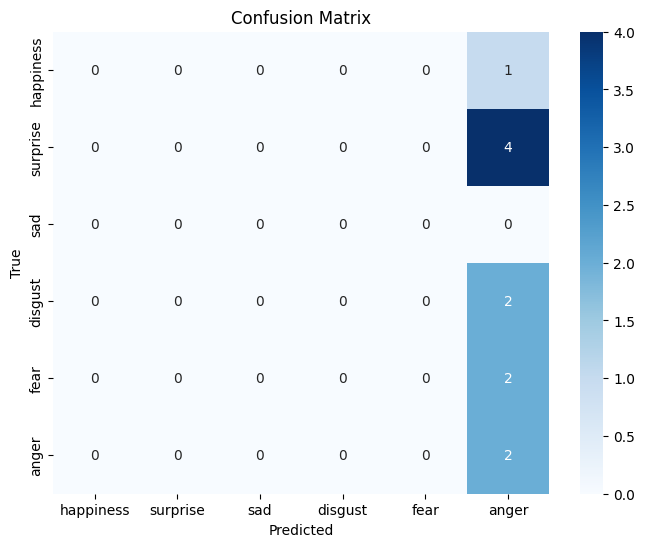

UF1: 0.0615, UAR: 0.2000


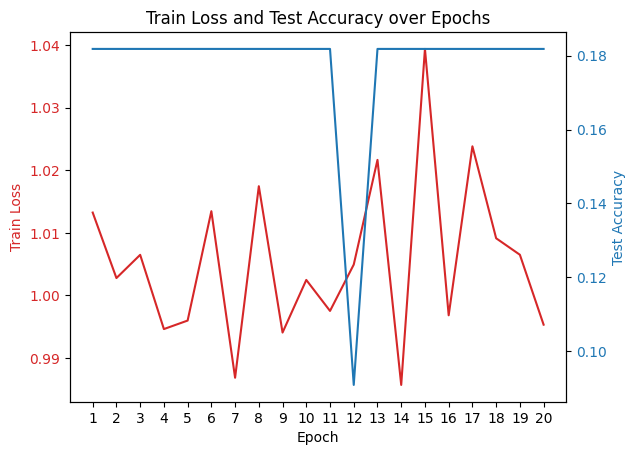

Tiempo total para el spNO.10: 1651.88. Promedio: 1651.88
Subject: spNO.11


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


spNO.11: Entró a train


KeyboardInterrupt: 

In [ ]:
# pos_margin=0, neg_margin=1
if __name__ == '__main__':
    main()

In [9]:
# pos_margin=0.2, neg_margin=1.5
if __name__ == '__main__':
    main()

cuda
Subject: spNO.10


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Epoch 1/20, Train Loss: 1.4351, Test Accuracy: 0.0000

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Epoch 2/20, Train Loss: 1.4209, Test Accuracy: 0.0000

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Epoch 3/20, Train Loss: 1.4151, Test Accuracy: 0.0000

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Epoch 4/20, Train Loss: 1.4050, Test Accuracy: 0.0000

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Epoch 5/20, Train Loss: 1.4017, Test Accuracy: 0.0000

spNO.10: Entró a train
spNO.10: Entró a test


KeyboardInterrupt: 

cuda
Subject: spNO.10
spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [1, 3, 1, 4, 3, 4, 3, 3, 4, 3, 4]
Epoch 1/20, Train Loss: 1.8538, Test Accuracy: 0.2727

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 2/20, Train Loss: 1.6399, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 3/20, Train Loss: 1.5784, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 4/20, Train Loss: 1.5903, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1]
Epoch 5/20, Train Loss: 1.5826, Test Accuracy: 0.2727

spNO.10: Entró a train


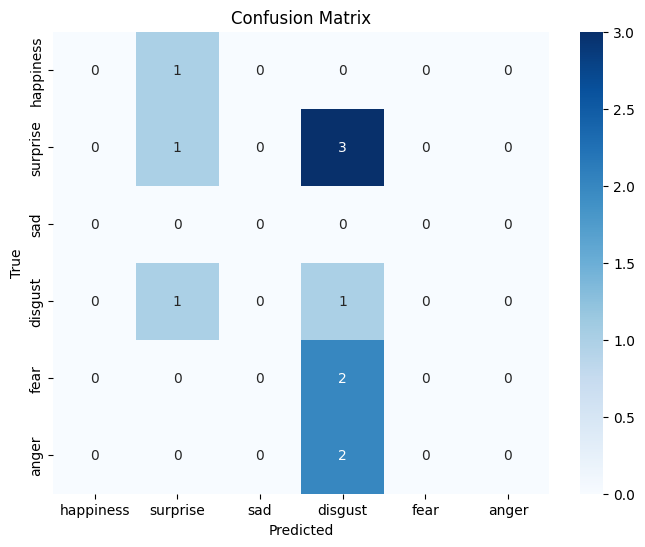

UF1: 0.0971, UAR: 0.1500


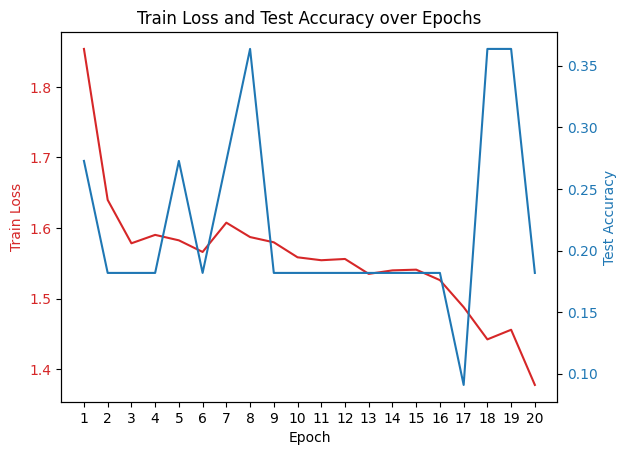

Tiempo total para el spNO.10: 812.98. Promedio: 812.98
Subject: spNO.11


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


spNO.11: Entró a train


KeyboardInterrupt: 

In [15]:
# cross entropy loss, freeze vit 6 st 2, 20 epochs
if __name__ == '__main__':
    main()

cuda
Subject: spNO.10


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 1/30, Train Loss: 1.9015, Test Accuracy: 0.2727

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 2/30, Train Loss: 1.6197, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 3/30, Train Loss: 1.6036, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch 4/30, Train Loss: 1.6065, Test Accuracy: 0.3636

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 5/30, Train Loss: 1.6034, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test


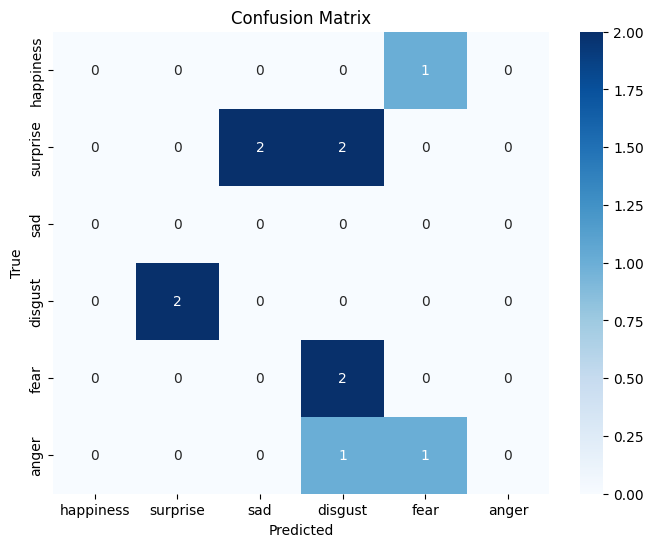

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


UF1: 0.0000, UAR: 0.0000


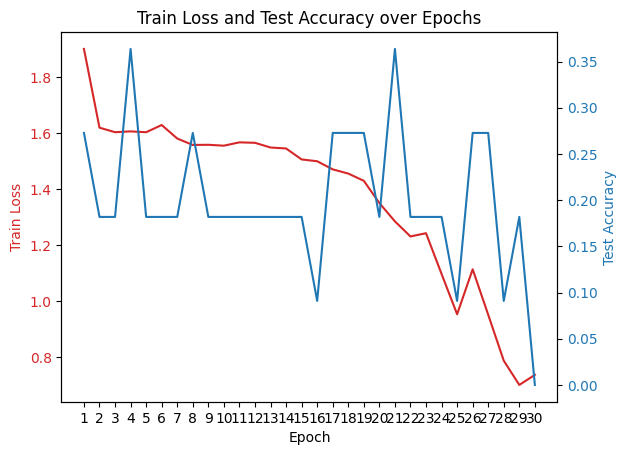

Tiempo total para el spNO.10: 1248.05. Promedio: 1248.05
Subject: spNO.11


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 1/30, Train Loss: 1.9844, Test Accuracy: 0.3846

spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 2/30, Train Loss: 1.6470, Test Accuracy: 0.3846

spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 3/30, Train Loss: 1.6308, Test Accuracy: 0.3846

spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 4/30, Train Loss: 1.6156, Test Accuracy: 0.3846

spNO.11: Entró a train


KeyboardInterrupt: 

In [9]:
# cross entropy loss, freeze vit 4 st 1
if __name__ == '__main__':
    main()

cuda
Subject: spNO.10


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 1/30, Train Loss: 1.8726, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1]
Epoch 2/30, Train Loss: 1.6407, Test Accuracy: 0.2727

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1]
Epoch 3/30, Train Loss: 1.5977, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 4/30, Train Loss: 1.5777, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 5/30, Train Loss: 1.5944, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test


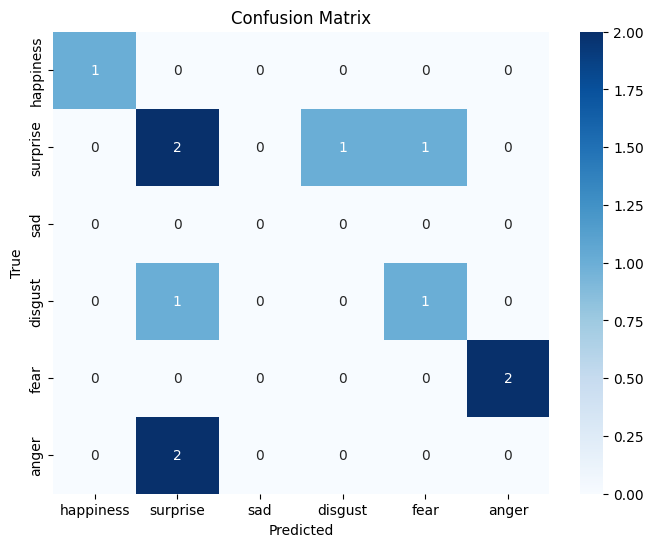

UF1: 0.2889, UAR: 0.3000


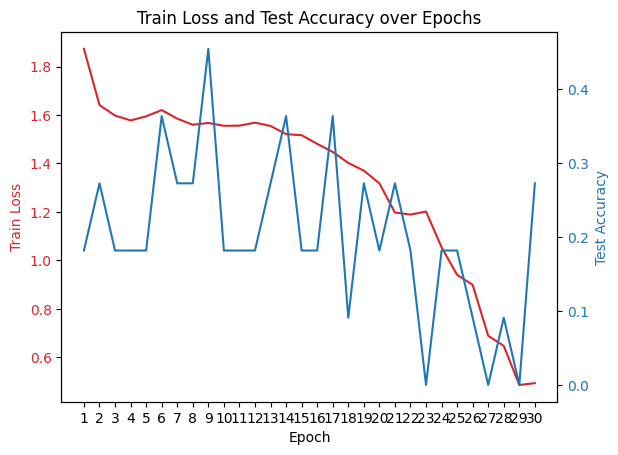

Tiempo total para el spNO.10: 1236.29. Promedio: 1236.29
Subject: spNO.11


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 1/30, Train Loss: 1.8592, Test Accuracy: 0.3846

spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3]
Epoch 2/30, Train Loss: 1.6060, Test Accuracy: 0.3077

spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 3/30, Train Loss: 1.5840, Test Accuracy: 0.3846

spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3]
Epoch 4/30, Train Loss: 1.6401, Test Accuracy: 0.3846

spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 5/30, Train Loss: 1.6351, Test Acc

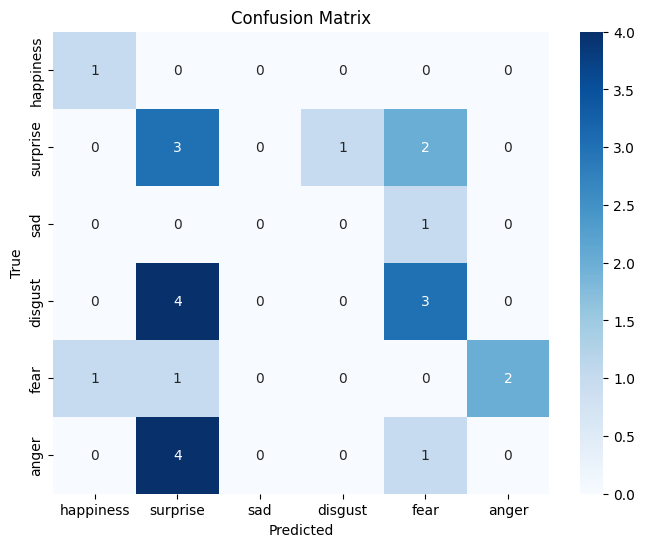

UF1: 0.1667, UAR: 0.2500


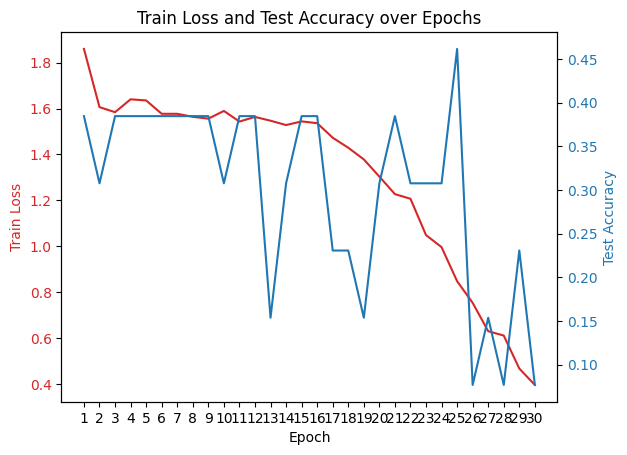

Tiempo total para el spNO.11: 1223.68. Promedio: 1229.98
Subject: spNO.13


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


spNO.13: Entró a train


KeyboardInterrupt: 

In [9]:
# cross entropy loss, freeze vit 6 st 2, 30 epochs
if __name__ == '__main__':
    main()

cuda
Subject: spNO.1


c:\Users\IALAB\anaconda3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


spNO.1: Entró a train
spNO.1: Entró a test
Labels:  [0, 0, 1, 1, 3]
Predictions:  [3, 3, 3, 3, 3]
Epoch 1/25, Train Loss: 1.8779, Test Accuracy: 0.2000

spNO.1: Entró a train
spNO.1: Entró a test
Labels:  [0, 0, 1, 1, 3]
Predictions:  [3, 3, 3, 3, 3]
Epoch 2/25, Train Loss: 1.6690, Test Accuracy: 0.2000

spNO.1: Entró a train
spNO.1: Entró a test
Labels:  [0, 0, 1, 1, 3]
Predictions:  [3, 3, 3, 3, 3]
Epoch 3/25, Train Loss: 1.6652, Test Accuracy: 0.2000

spNO.1: Entró a train
spNO.1: Entró a test
Labels:  [0, 0, 1, 1, 3]
Predictions:  [3, 3, 3, 3, 3]
Epoch 4/25, Train Loss: 1.6320, Test Accuracy: 0.2000

spNO.1: Entró a train
spNO.1: Entró a test
Labels:  [0, 0, 1, 1, 3]
Predictions:  [3, 3, 3, 3, 3]
Epoch 5/25, Train Loss: 1.6422, Test Accuracy: 0.2000

spNO.1: Entró a train
spNO.1: Entró a test
Labels:  [0, 0, 1, 1, 3]
Predictions:  [3, 3, 3, 3, 3]
Epoch 6/25, Train Loss: 1.6276, Test Accuracy: 0.2000

spNO.1: Entró a train
spNO.1: Entró a test
Labels:  [0, 0, 1, 1, 3]
Predictions:  

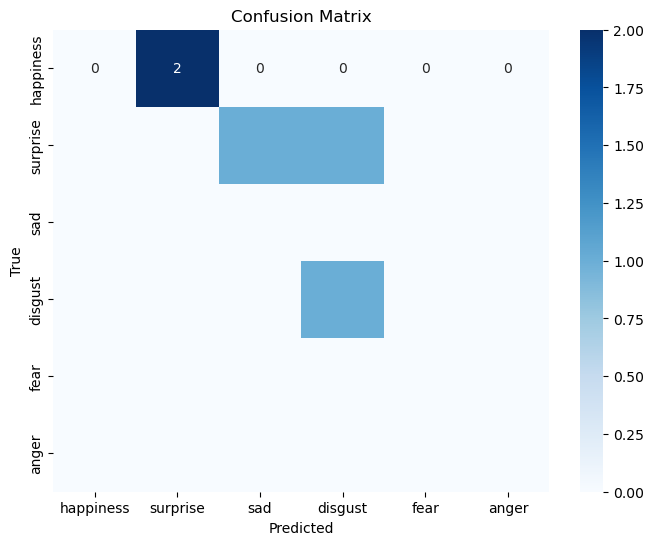

UF1: 0.1667, UAR: 0.2500


c:\Users\IALAB\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


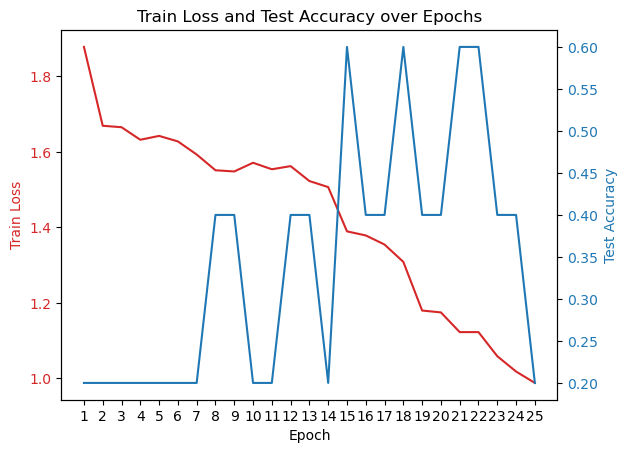

Tiempo total para el spNO.1: 986.32. Promedio: 986.32
Subject: spNO.10
spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 1/25, Train Loss: 1.8644, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 2/25, Train Loss: 1.6336, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 3/25, Train Loss: 1.6113, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 4/25, Train Loss: 1.5938, Test Accuracy: 0.1818

spNO.10: Entró a train
spNO.10: Entró a test
Labels:  [0, 1, 1, 1, 1, 3, 3, 4, 4, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 5/25, Train Loss: 1.579

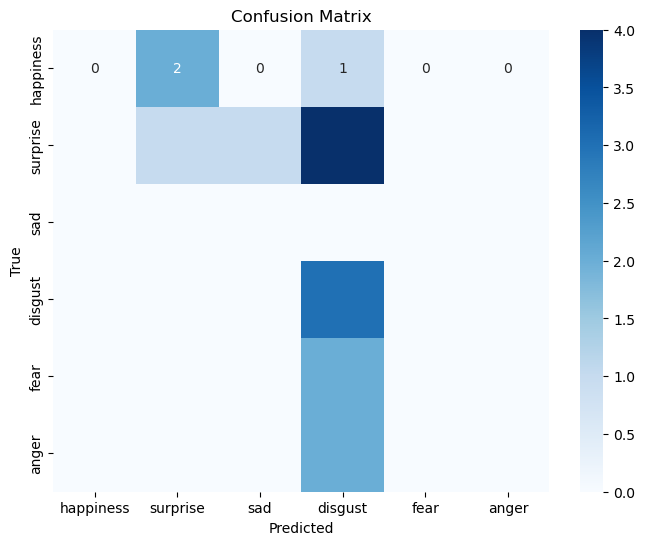

UF1: 0.1037, UAR: 0.1944


c:\Users\IALAB\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


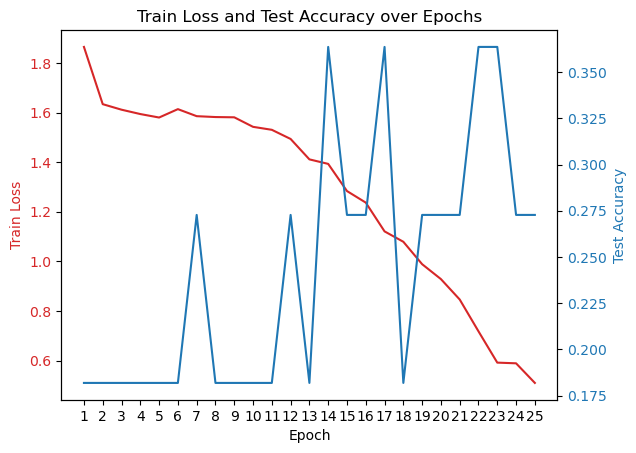

Tiempo total para el spNO.10: 1175.47. Promedio: 1080.89
Subject: spNO.11
spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 1/25, Train Loss: 1.9008, Test Accuracy: 0.3846

spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 2/25, Train Loss: 1.6931, Test Accuracy: 0.3846

spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 3/25, Train Loss: 1.6256, Test Accuracy: 0.3846

spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 4/25, Train Loss: 1.6171, Test Accuracy: 0.3846

spNO.11: Entró a train
spNO.11: Entró a test
Labels:  [1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5]
Predictions:  [1, 3,

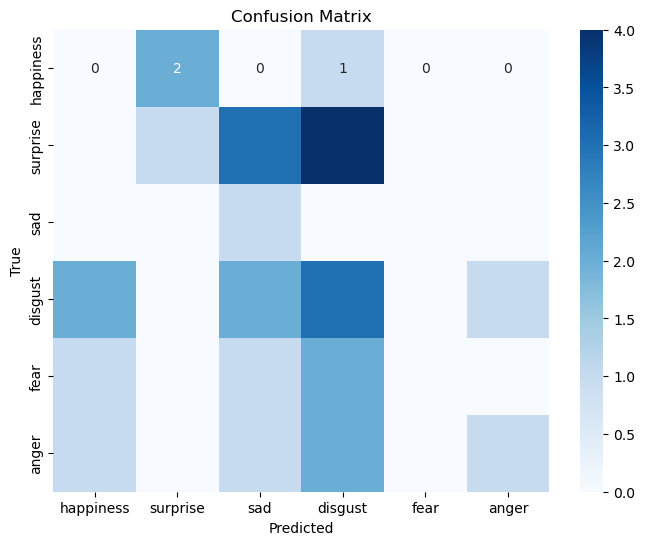

UF1: 0.1650, UAR: 0.2833


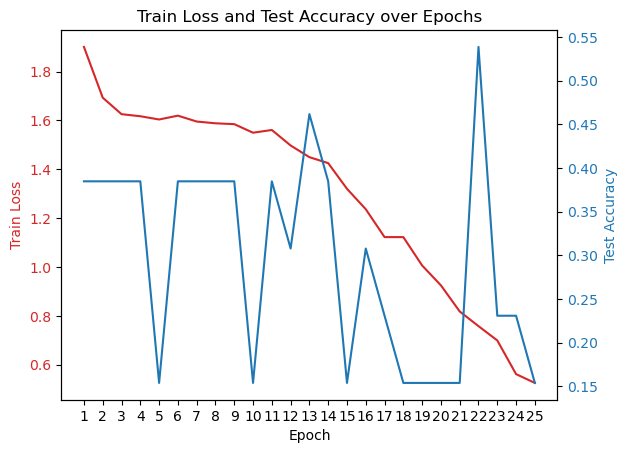

Tiempo total para el spNO.11: 1145.57. Promedio: 1102.45
Subject: spNO.12
spNO.12: Entró a train


KeyboardInterrupt: 

In [7]:
# PROBAR MAÑANA CON 25 ITERACIONES, TODOS LOS SUJETOS, CONGELAR VIT 6 ST 2
if __name__ == '__main__':
    main()

### Último

In [9]:
# 22 iteraciones, borré el del model, del optimizer y el gc.collect()
if __name__ == '__main__':
    main()

cuda
Subject: spNO.1
spNO.1: Entró a train


KeyboardInterrupt: 